<a href="https://colab.research.google.com/github/MadhabBarman/Epidemic-Control-Model/blob/master/SEAIRD_Control_Model_two_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/MadhabBarman/Epidemic-Control-Model.git

In [ ]:
cd Epidemic-Control-Model/

In [3]:
%matplotlib inline
import numpy as np
import  matplotlib.pyplot as plt
import  pandas as pd
from scipy.integrate import odeint
from scipy.io import savemat, loadmat
import numpy.linalg as la

M = 16  #Number of age-group
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
Real_data = np.genfromtxt('data/covid-cases/case_time_series.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

#Ni= total population for age-group-i, N=Total population
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

######################### contact matrices###################################
#Home contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)
#Workspace Contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)
#School Conact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)
#Others Contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)
CM = CH + CW + CS + CO

my_data_nw = np.genfromtxt('data/covid-cases/india_10april.txt', delimiter='', skip_header=6)
death_case, active_case = my_data_nw[:,4], my_data_nw[:,5]

active = Real_data[:,7]
active_new = active[34:107]
death = Real_data[:,6]
death_new = death[34:107]

In [4]:
alpha_d = 0.05    #fractional constant     
beta  = 0.379     #rate if infection
rho = 0.75        #control parameter of H
xi = 0.29         #recovery rate of E
alpha_1 = 0.7     #fractional part of E-->Q
alpha_2 = 0.2     #fractional part of E-->A
alpha_3 = 1-(alpha_1+alpha_2)    #fractional part of E-->I
phi_qh  = 1/10       #Recovery rate of Q-->H
q = 0.1      #(0.1)  #fractional part of Q-->H
g_as  = 0.1          #rate A-->I
d_ar  = 2./7         #Recovery rate of A
phi_sh = 1./2        #rate I-->H 
d_sr =  1./7         #Recovery rate of I
d_hr = (1-alpha_d)/10            #Recovery rate of H 
eta = alpha_d/10     #Death rate
fsa = 0.1            #Fraction of the contact matrix Cs 
fsh = 0.1            #Fraction of the contact matrix Ch 


# initial conditions
E_0 = np.zeros((M));
Q_0  = np.zeros((M))
A_0 = np.zeros((M))
I_0 = np.zeros((M));  I_0[6:13]=2;  I_0[2:6]=1
H_0  = np.zeros((M))
R_0  = np.zeros((M))
D_0  = np.zeros((M))
S_0  = Ni - (E_0+ Q_0 + A_0 + I_0 + H_0 + R_0 + D_0)

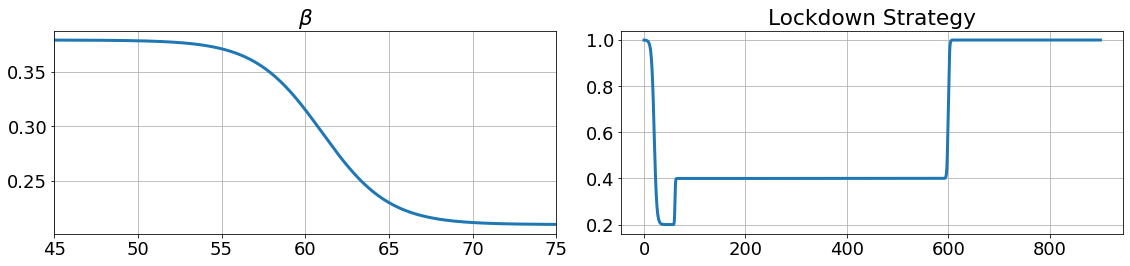

In [8]:
Tf = 900; Nf = 9000 #Tf -->final time from 0, Nf-->total number points
t = np.linspace(0,Tf,Nf)

uc = lambda t:0.2*0.5*(1*np.tanh((t - 61)/1)-1*np.tanh((t - 600)/1))+0.6-\
0.8*0.5*(np.tanh((t - 20)/5))+0.8*0.5*(np.tanh((t - 600)/2))+0.4 #+0.2*(np.tanh((t-400))-np.tanh((t-86)/2))
t_won = 5
t_woff = 1
#uc = lambda t, t_on, t_off, t_won, t_woff, pld: 1 + pld*0.5*(np.tanh((t - t_off - t_won)/t_woff) - np.tanh((t - t_on)/t_won))

R_0_starts, ks, x0s, R_0_ends = beta, 0.5, 61, 0.21 #beta
def beta_f(t):
    return ((R_0_starts-R_0_ends) / (1 + np.exp(-ks*(-t+x0s))) + R_0_ends)
plt.figure(figsize=(16,4))
plt.rcParams['font.size']=18
plt.subplot(1,2,1)
plt.plot(t,beta_f(t),lw=3);
plt.title(r'$\beta$')
plt.grid(True)
plt.xlim(45,75)
plt.subplot(1,2,2)
plt.plot(t, uc(t),lw=3)
plt.title('Lockdown Strategy')
plt.grid(True)
plt.tight_layout(True)
#plt.savefig('lockd.png',format='png', dpi=200)
#save_results_to = 'C:/Users/HP/Desktop/Lat_radon/double peak/EPS_file/'
#plt.savefig(save_results_to + 'lockd.png', dpi = 200)

In [9]:
def cont(t):
    return CH   + uc(t)*(CW + CO + CS)
    #return CH   + uc(t,20,600,t_won, t_woff,0.8)*(CW + CO + CS)
    #return CM if t<21 else CH

#  S=y[i], E=y[M+i], Q=y[2M+i],A=y[3M+i], I=y[4M+i], H=y[5M+i], R=y[6M+i] for i=1,2,3,...,M

dy = np.zeros(7*M)
def rhs(y, t, cont, beta_f):
    CM = cont(t)  #contact matrix
    for i in range(M):
        lmda=0
        for j in range(M):
            lmda += beta_f(t)*(CM[i,j]*y[3*M+j] + fsa*CM[i,j]*y[4*M+j] +fsh*(1.0-rho)*CM[i,j]*y[5*M+j])/Ni[j]   
        dy[i]     = - lmda*y[i]  + (1-q)*phi_qh*y[2*M+i]   # S susceptibles
        dy[i+M]   =   lmda*y[i]  - xi*y[M+i]   #E exposed class 
        dy[i+2*M] = alpha_1*xi*y[M+i] - phi_qh*y[2*M+i]   #Q Quarantined 
        dy[i+3*M] = alpha_2*xi*y[M+i] - (g_as + d_ar )*y[3*M+i]     #A Asymptomatic infected 
        dy[i+4*M] = alpha_3*xi*y[M+i] + g_as*y[3*M+i] - (phi_sh + d_sr)*y[4*M+i]  #I Symptomatic infected 
        dy[i+5*M] = phi_sh*y[4*M+i] + q*phi_qh*y[2*M+i] - (d_hr + eta)*y[5*M+i]  #H Isolated
        dy[i+6*M] = d_ar*y[3*M+i] + d_sr*y[4*M+i] + d_hr*y[5*M+i]  #Recovered
    return dy
        
data = odeint(rhs, np.concatenate((S_0, E_0, Q_0, A_0, I_0, H_0, R_0)), t, args=(cont,beta_f))
tempS, tempE, tempQ, tempA, tempI, tempH, tempR = np.zeros((Nf)),\
np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf))
for i in range(M):
    tempS += data[:, 0*M + i]
    tempE += data[:, 1*M + i]
    tempQ += data[:, 2*M + i]
    tempA += data[:, 3*M + i]
    tempI += data[:, 4*M + i]
    tempH += data[:, 5*M + i]
    tempR += data[:, 6*M + i]
IC_death = N - (tempS + tempE + tempQ + tempA + tempI + tempH + tempR)

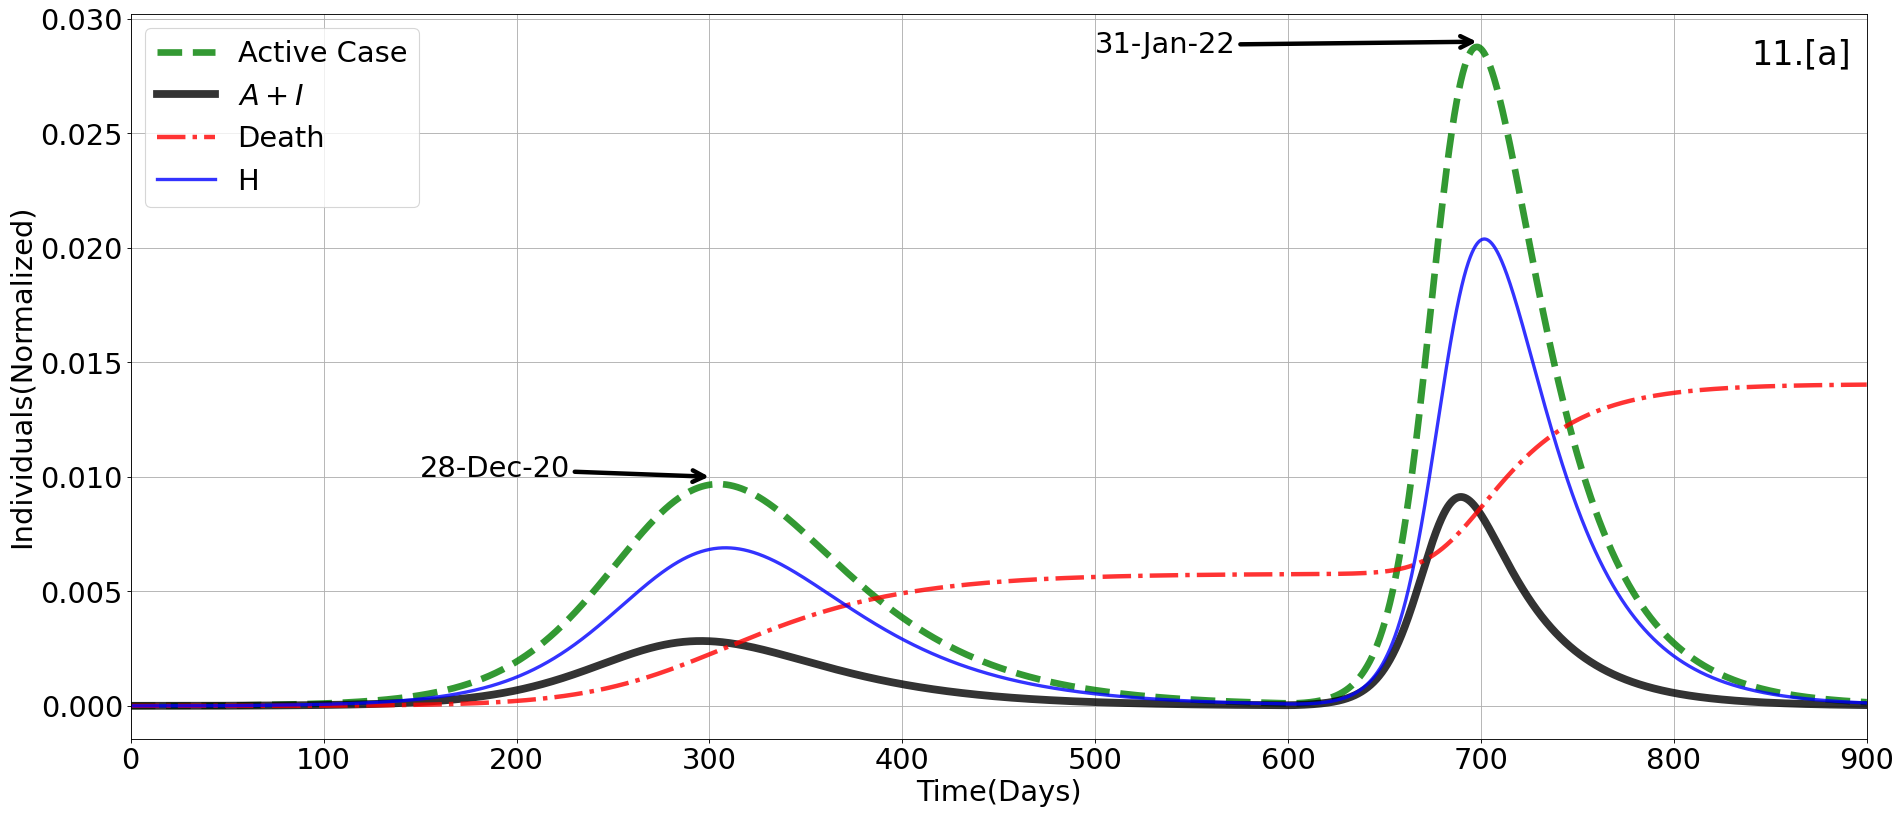

In [10]:
fig = plt.figure(num=None, figsize=(28, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})
plt.plot(t, (tempA + tempI + tempH)/N, '--', lw=6, color='g', label='Active Case', alpha=0.8)
plt.plot(t, (tempA + tempI)/N , '-', lw=7, color='k', label='$A + I$', alpha=0.8)
plt.plot(t, IC_death/N, '-.', lw=4, color='r', label='Death', alpha=0.8)
plt.plot(t, tempH/N, '-', lw=3, color='b', label='H', alpha=0.8)
dt = np.linspace(0,Tf,Nf)[1]
day = int(dt*100)
plt.legend(fontsize=26, loc='upper left'); plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals(Normalized)');
plt.xlabel('Time(Days)');
plt.annotate('28-Dec-20', xy=(301, 0.010), xytext=(150, 0.010),
            arrowprops=dict(arrowstyle="->",facecolor='black',lw=4))
plt.annotate('31-Jan-22', xy=(699, 0.029), xytext=(500, 0.0285),
            arrowprops=dict(arrowstyle="->",facecolor='black',lw=4));
#plt.text(840,0.028,'11.[a]',fontsize=30);
#plt.savefig(save_results_to +'two_wave200.pdf',format='pdf', dpi=200)
#plt.savefig(save_results_to +'Figure11a.png',format='png', dpi=200)

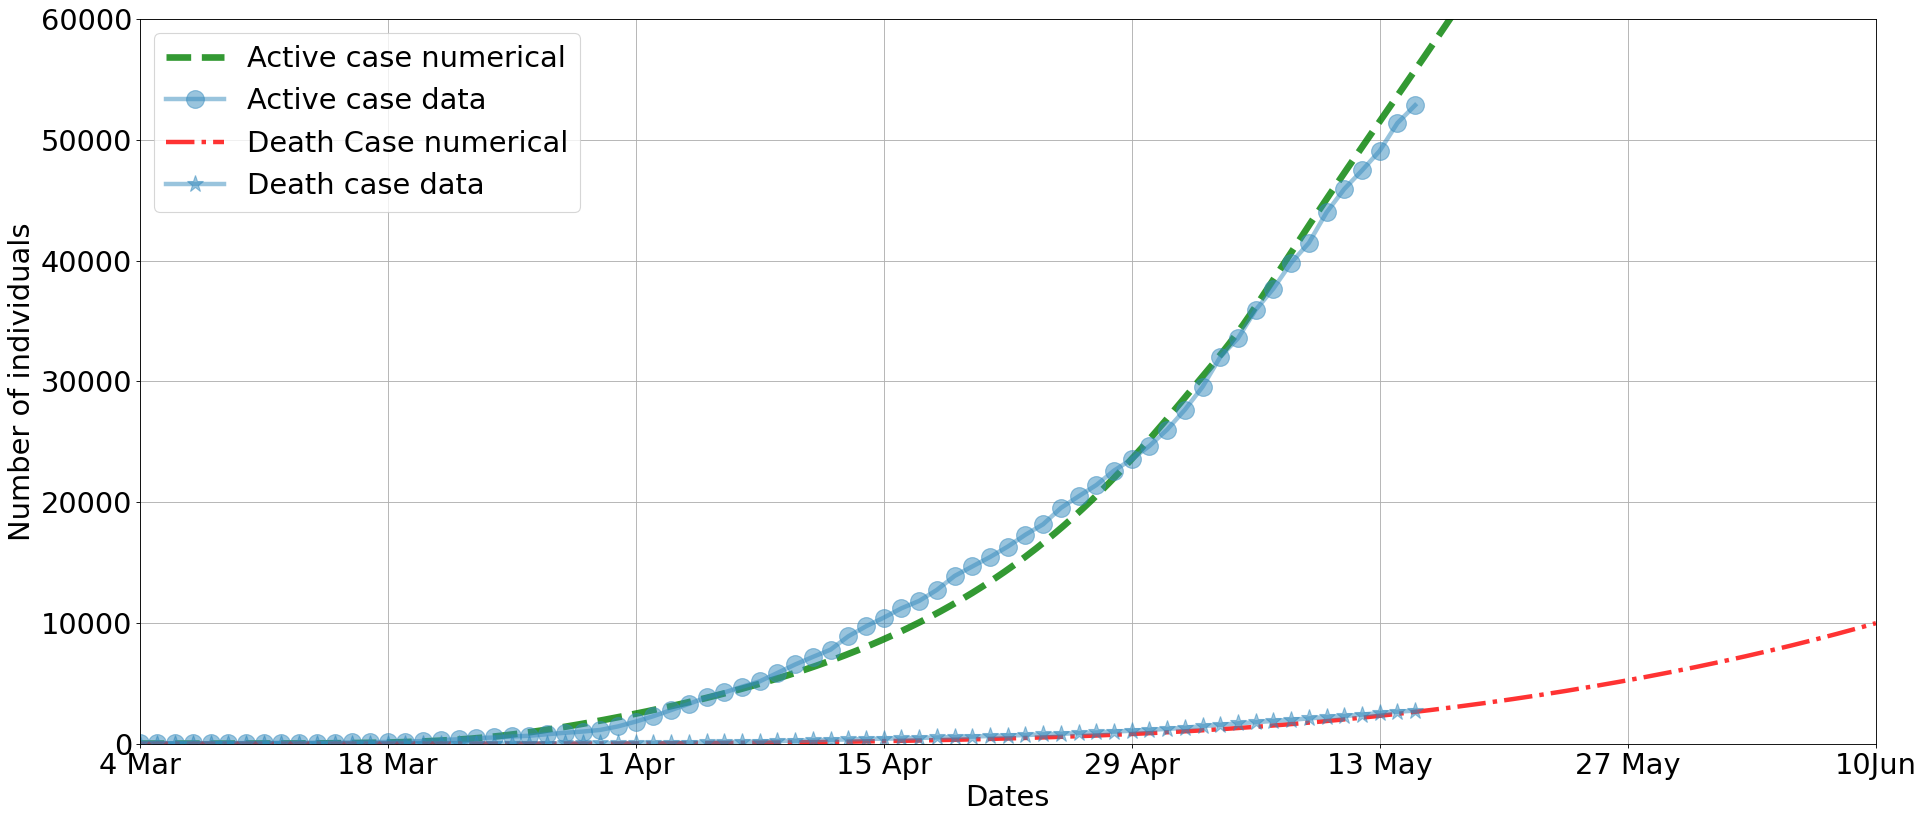

In [22]:
fig = plt.figure(num=None, figsize=(28, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26, 'text.color':'black'})
#plt.plot(t, D61_withouts, '-', lw=4, color='b', label='LD-I', alpha=0.8)
plt.plot(t, (tempA + tempI + tempH), '--', lw=6, color='g', label='Active case numerical', alpha=0.8)
plt.plot(active_new, 'o-', lw=4, color='#348ABD', ms=16, label='Active case data', alpha=0.5)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun','24Jun'));
plt.plot(t, IC_death, '-.', lw=4, color='r', label='Death Case numerical', alpha=0.8)
plt.plot(death_new, '-*', lw=4, color='#348ABD', ms=16, label='Death case data', alpha=0.5)
plt.legend(fontsize=26, loc='best'); plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Number of individuals');
plt.ylim(0, 60000);
plt.xlim(0, 98);
plt.xlabel('Dates');
#plt.text(7*14-7.5,55000,'11.[b]',fontsize=30);
#plt.savefig(save_results_to +'Figure11b.png',format='png', dpi=200)

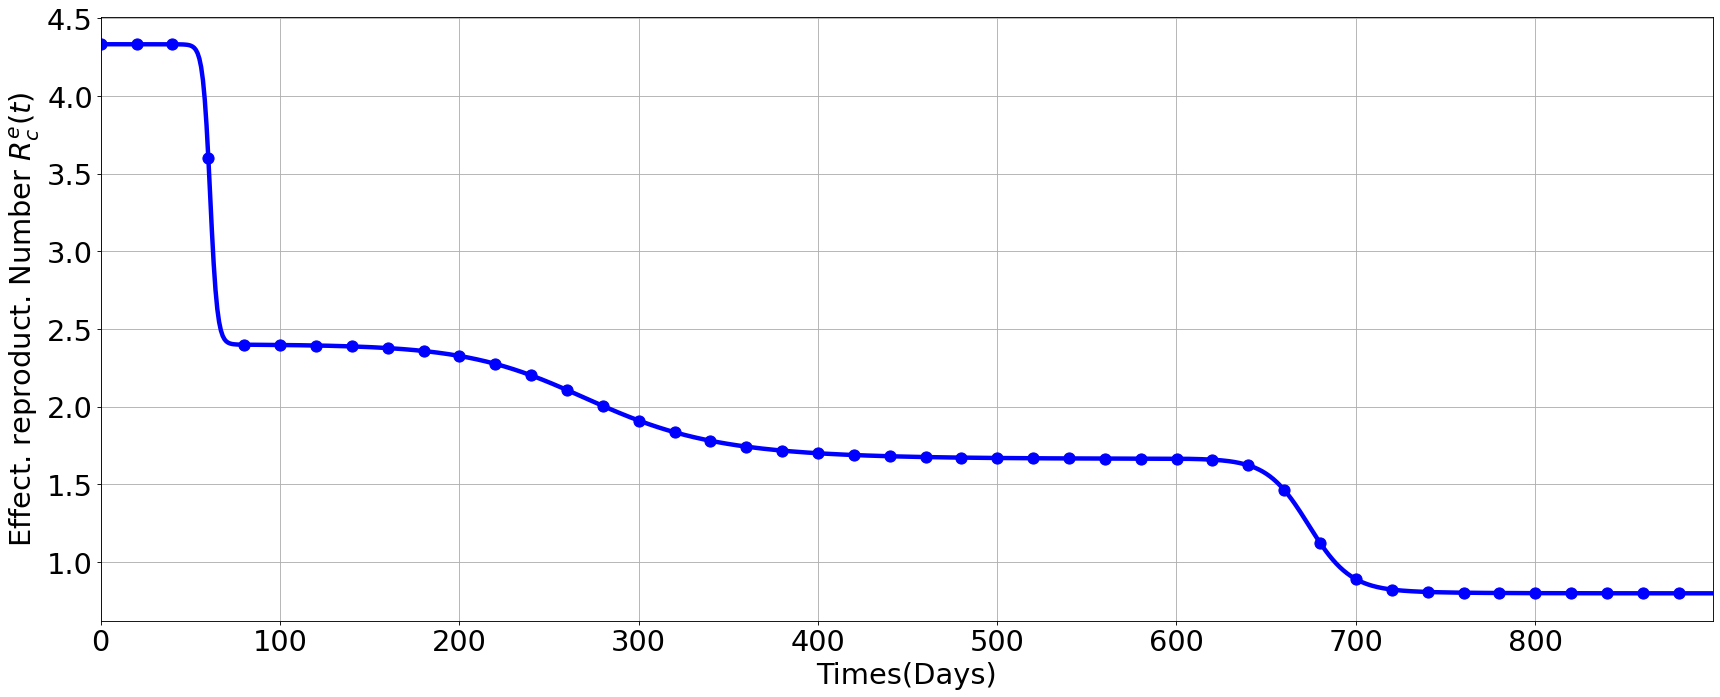

In [21]:
beta = beta_f(t)
F = np.array([[xi, 0, 0, 0, 0], [-alpha_1*xi, phi_qh, 0, 0, 0], [-alpha_2*xi, 0, g_as+d_ar, 0, 0],\
[-alpha_3*xi,  0, -g_as, phi_sh+d_sr, 0], [0, -q*phi_qh, 0, -phi_sh, d_hr+eta]])
Id = np.identity(M)
Sigma = np.kron(F, Id)
L0 = np.zeros((M, M))
r0 = np.zeros((Tf))
for tt in range(Tf):
    Si = np.array((data[tt*10,0:M])).flatten()
    for i in range(M):
        for j in range(M):
            L0[i,j]=CM[i,j]*Si[i]/Ni[j]
    T = np.zeros_like(Sigma)
    T[0:M, 2*M:3*M] = beta[tt*10]*L0
    T[0:M, 3*M:4*M] = fsa*beta[tt*10]*L0
    T[0:M, 4*M:5*M] = fsh*beta[tt*10]*(1-rho)*L0
    Sigma_inv = la.inv(Sigma)
    R = np.dot(T, Sigma_inv)
    r0[tt] = np.real( np.max(np.linalg.eigvals(R)))
xx = t[::10];    
plt.figure(figsize=(26,10),dpi=80,num=None) 
plt.rcParams.update({'font.size': 26})
plt.plot(xx[::20], r0[::20],'.',markersize=20,c='b') ;
plt.plot(xx, r0,'-',c='b',lw=4) ;
plt.xlabel('Times(Days)')
plt.ylabel(r'Effect. reproduct. Number $R_c^e(t)$');
plt.autoscale(enable=True,axis='x', tight=True)
plt.grid(True)
#plt.savefig('two_wave_b_constR.png',format='png',dpi=200)
#savemat('R_r0_q1.mat', {'r0':r0})